## Import Necessary Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
import os
import re
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Load the dataset

In [2]:
%%time
for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
    #print(os.path.join(dirname, filenames))
    print(dirname)

/kaggle/input
/kaggle/input/imdb-review
/kaggle/input/imdb-review/aclImdb
/kaggle/input/imdb-review/aclImdb/test
/kaggle/input/imdb-review/aclImdb/test/pos
/kaggle/input/imdb-review/aclImdb/test/neg
/kaggle/input/imdb-review/aclImdb/train
/kaggle/input/imdb-review/aclImdb/train/pos
/kaggle/input/imdb-review/aclImdb/train/neg
/kaggle/input/imdb-review/aclImdb/train/unsup
CPU times: user 637 ms, sys: 1.84 s, total: 2.48 s
Wall time: 39.9 s


In [3]:
#helper functions to lead the data
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

In [4]:
%%time

train = load_dataset('/kaggle/input/imdb-review/aclImdb/train')
test = load_dataset('/kaggle/input/imdb-review/aclImdb/test')

CPU times: user 6.95 s, sys: 6.22 s, total: 13.2 s
Wall time: 2min 3s


In [5]:
train.head()

,sentence,sentiment,polarity
0,A have a female friend who is currently being ...,9,1
1,I'm not ruining anything when I inform you tha...,4,0
2,"This movie has it all, action, fighting, danci...",9,1
3,and anyone who watches this film will agree. T...,10,1
4,I love Korean films because they have the abil...,10,1


In [6]:
test.head()

,sentence,sentiment,polarity
0,Just watched this film on TV and it was awesom...,10,1
1,I am not a fan of the original book but was ex...,2,0
2,Although unusually in colour for a second stri...,2,0
3,We usually think of the British as the experts...,10,1
4,Since there have been so many reviews of this ...,10,1


## Preprocessing

In [7]:
train.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [8]:
train_texts = train['sentence'].values
train_labels = train['polarity'].values
test_texts = test['sentence'].values
# test_labels = test['polarity'].values

labels_index = {'pos':1, 'neg':0} 

In [9]:
test.columns

Index(['sentence', 'sentiment', 'polarity'], dtype='object')

In [10]:
test_labels = test['polarity'].values
test_labels

array([1, 0, 0, ..., 1, 0, 1])

We need to design an sklearn pipeline with our model. What is a pipeline?

**Pipeline** is just an abstract notion, it's not some existing ml algorithm. Often in ML tasks you need to perform sequence of different transformations (find set of features, generate new features, select only some good features) of raw dataset before applying final estimator. Pipeline gives you a single interface for all 3 steps of transformation and resulting estimator. It encapsulates transformers and predictors inside

**Transformer** in scikit-learn - some class that have fit and transform method, or fit_transform method.

**Predictor** - some class that has fit and predict methods, or fit_predict method.

In [11]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 1000 # Max number of words kept at the end of each text

## Transform text to `id`

In [12]:
class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

## Padding

In [13]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

## Create the model

In [14]:
batch_size = 64
max_features = vocab_size + 1

#Training an LSTM with embedding on the fly
def create_model(max_features):
    """ Model creation function: returns a compiled LSTM"""


    rnnmodel = Sequential()
    rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
    rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    rnnmodel.add(Dense(1, activation='sigmoid'))
    rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return rnnmodel

## Build the Pipeline

In [15]:
# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model,
                               epochs=2, 
                               batch_size=32, 
                               max_features=max_features, 
                               verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(train_texts, train_labels);

2022-11-20 08:59:53.727047: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-20 08:59:54.205862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/2
782/782 [==============================] - 4112s 5s/step - loss: 0.4305 - accuracy: 0.8055
Epoch 2/2
782/782 [==============================] - 4063s 5s/step - loss: 0.2960 - accuracy: 0.8801


## Prediction

In [16]:
y_preds = pipeline.predict(test_texts)

## Classification Report

In [17]:
print('Test accuracy: {:.2f} %'.format(100*accuracy_score(y_preds, test_labels)))

print(classification_report(y_preds, test_labels, target_names = ['Negative','Positive']))

Test accuracy: 85.00 %
              precision    recall  f1-score   support

    Negative       0.82      0.88      0.84     11641
    Positive       0.88      0.83      0.86     13359

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



## Interpret predictions using Lime

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

In [19]:
# We choose a sample from test set
idx = 11
text_sample = test_texts[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 1000 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-1000:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[test_labels[idx]])

Sample 11: last 1000 words (only part used by the model)
--------------------------------------------------
Saw this at Newport Beach Film Festival the other day. The film is REALLY exceptional. The crowd I went with all loved it. Funny, poignant and great acting. I'm tired of the tried and true Hollywood romances, who can relate? David Krumholtz (Max) is really amazing as the sure and true lover of the ultra-screwy Grace (Natasha Lyonne, who is also excellent). When Max falls for Grace we believe it. Why? Because love at first sight IS crazy and we're dealing with two lost, and maybe not so crazy, souls. Also of note are Giullmo Diaz as Hector and Rosanna Arquette as a sexless/sexy neurotic, both "roommates" of Max and Grace before they embark on their trip to Sheboygen, WI and finding themselves. Don't miss this one, its something special! P.S. The soundtrack, led by Kevin Hearn (of Bare Naked Ladies fame) is really super super cool as well.
------------------------------------------

In [20]:
explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})
lime_weights

,words,weights
0,super,0.028887
1,cool,0.023460
2,well,0.022791
3,and,0.015038
4,true,0.012074
5,falls,-0.001945
6,Bare,-0.001526
7,as,0.000954
8,Grace,0.000548
9,acting,-0.000213


Text(0.5, 1.0, 'Sample 11 features weights given by LIME')

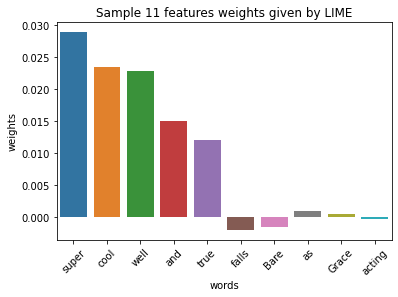

In [21]:
sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx))